Visualizing a few images from the CIFAR-10 dataset

100%|██████████| 170498071/170498071 [00:12<00:00, 13131370.74it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


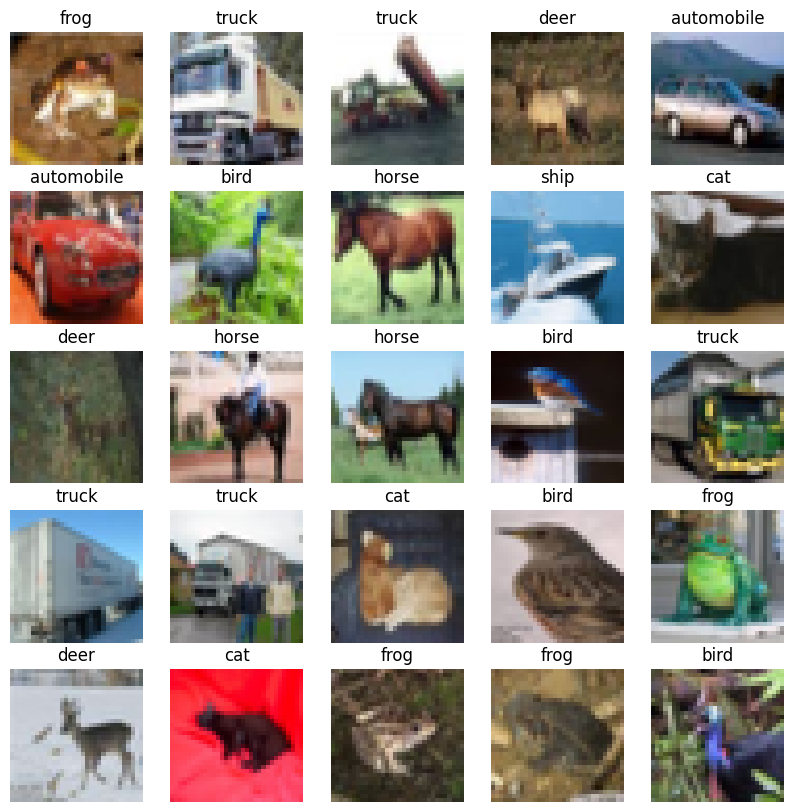

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms

# Define the class names
class_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

# Load the CIFAR-10 dataset and apply transformations
transform = transforms.Compose([transforms.ToTensor()])
cifar_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Define a function to display a grid of images from the dataset
def display_images_grid(images, titles, rows, cols):
    fig, axs = plt.subplots(rows, cols, figsize=(10,10))
    for i in range(rows):
        for j in range(cols):
            axs[i,j].imshow(np.transpose(images[i*cols+j].numpy(), (1, 2, 0)))
            axs[i,j].set_title(class_names[titles[i*cols+j]])
            axs[i,j].axis('off')
    plt.show()

# Display a grid of 25 images from the dataset
images = []
titles = []
for i in range(25):
    image, label = cifar_dataset[i]
    images.append(image)
    titles.append(label)
display_images_grid(images, titles, 5, 5)

'DatasetFetcher' allows fetching and preparing data loaders for the CIFAR-10 dataset using PyTorch's DataLoader class. The class supports data augmentation and normalization. The data augmentation consists of random horizontal flip, random crop, and equalization of the image. The normalization is based on the mean and standard deviation of the training dataset. The code initializes the 'DatasetFetcher' object, adds data augmentation and normalization, and retrieves the training and testing data loaders. The batch_size parameter specifies the number of samples per batch, while size and padding parameters in dataAugmentation method control the size and padding of the random crop.

In [2]:
import torch
import multiprocessing
import torchvision
# import numpy as np
from torch.utils.data import DataLoader

class DatasetFetcher:
    
    def __init__(self, dataset="CIFAR10", batch_size=128):
        # Initialize the class with the specified dataset name and batch size
        print("Initializing fetching %s dataset using torchvision"%(dataset))
        self.datasetObject = torchvision.datasets.__dict__.get(dataset, None)
        if self.datasetObject == None:
            raise Exception("Dataset %s not available in torchvision."%(dataset))
        self.batch_size = batch_size
        self.train_transformers = []
        self.test_transformers = []
        self.workersAvailable = min(multiprocessing.cpu_count(), 14)

    def augmentData(self):
        # Add a transformer that randomly flips the image horizontally during training
        self.train_transformers.append(torchvision.transforms.RandomHorizontalFlip())
        # Add a transformer that randomly crops the image during training
        self.train_transformers.append(torchvision.transforms.RandomCrop(size=32, padding=3))
        # Add a transformer that equalizes the histogram of the image during both training and testing
        self.train_transformers.append(torchvision.transforms.functional.equalize)
        self.test_transformers.append(torchvision.transforms.functional.equalize)

    def __addToTensor(self):
        # Helper function to add a transformer that converts the image to a tensor during both training and testing
        self.train_transformers.append(torchvision.transforms.ToTensor())
        self.test_transformers.append(torchvision.transforms.ToTensor())
        
    def __loadTrainNormalizers(self):
        # Helper function to load the mean and standard deviation of the training dataset
        params = np.load("./trainNormalizedParameters.npz")
        return params['mean'], params['std']

    def addNormalizer(self):
        # Add a transformer that normalizes the image during both training and testing
        self.__addToTensor()
        trainingDataset = self.datasetObject(root="./data", train=True, download=True)
        trainData = trainingDataset.data/255.0
        mean = trainData.mean(axis=(0, 1, 2))
        std = trainData.std(axis=(0, 1, 2))
        np.savez("./trainNormalizedParameters", mean=mean, std=std)
        self.train_transformers.append(torchvision.transforms.Normalize(mean=mean, std=std))
        self.test_transformers.append(torchvision.transforms.Normalize(mean=mean, std=std))
 
        # function to get train and test loaders
    def getLoaders(self):
        # check if train transformers are empty and add 'ToTensor' transformer
        if len(self.train_transformers) == 0:
            self.__addToTensor()
            
        # create training dataset using the 'train_transformers'
        train_dataset = self.datasetObject(
            root="./data", train=True, download=True,
            transform=torchvision.transforms.Compose(self.train_transformers)
        )
        
        # create testing dataset using the 'test_transformers'
        test_dataset = self.datasetObject(
            root="./data", train=False, download=True,
            transform=torchvision.transforms.Compose(self.test_transformers)
        )
        
        # create train loader using the training dataset
        train_loader = DataLoader(
            train_dataset, batch_size=self.batch_size, shuffle=True,
            num_workers=self.workersAvailable
        )
        
        # create test loader using the testing dataset
        test_loader = DataLoader(
            test_dataset, batch_size=self.batch_size, shuffle=False,
            num_workers=self.workersAvailable
        )
        
        return train_loader, test_loader

    # function to get test loader
    def getTestLoader(self):
        # get mean and std dev of train dataset
        mean, std = self.__loadTrainNormalizers()
        
        # append 'ToTensor' and 'Normalize' transformers to 'test_transformers'
        self.test_transformers.append(torchvision.transforms.ToTensor())
        self.test_transformers.append(torchvision.transforms.Normalize(mean=mean, std=std))
        
        # create testing dataset using the updated 'test_transformers'
        test_dataset = self.datasetObject(
            root="./data", train=False, download=True,
            transform=torchvision.transforms.Compose(self.test_transformers)
        )
        
        # create test loader using the testing dataset
        test_loader = DataLoader(
            test_dataset, batch_size=self.batch_size, shuffle=False,
            num_workers=self.workersAvailable
        )
        
        return test_loader

# main code block
if __name__ == "__main__":
    # create an instance of DatasetFetcher class with CIFAR10 dataset and batch size of 128
    df = DatasetFetcher(dataset="CIFAR10", batch_size=128)
    
    # add transformations to the dataset
    df.augmentData()
    df.addNormalizer()
    
    # get train and test loaders using the added transformations
    train_loader, test_loader = df.getLoaders()

   

Initializing fetching CIFAR10 dataset using torchvision
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified



Worked on the basic resnet model from https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py \\
C - Number of channels \\
F - Filter size \\
K - Kernel size \\
P - Pool size \\

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):

    def __init__(self, in_planes, planes, kernel_size, skip_kernel, stride=1):
        super(BasicBlock, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=kernel_size, stride=stride, padding=1, bias=False)
         # Batch normalization layer after the first convolution
        self.bn1 = nn.BatchNorm2d(planes)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=kernel_size, stride=1, padding=1, bias=False)
        # Batch normalization layer after the second convolution
        self.bn2 = nn.BatchNorm2d(planes)

         # Shortcuts are used to add the input to the output of the residual block
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
           # If the input and output dimensions are not the same, use a convolutional layer to match the dimensions
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=skip_kernel, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
      # Apply the first convolutional layer, followed by batch normalization and ReLU activation
        out = F.relu(self.bn1(self.conv1(x)))
        # Apply the second convolutional layer, followed by batch normalization
        out = self.bn2(self.conv2(out))
        # Add the shortcut connection
        out += self.shortcut(x)
         # Apply ReLU activation to the output
        out = F.relu(out)
        return out

class ResNet(nn.Module):

    def __init__(self,N:int, B:list, C:list, F:list, K:list, P:int, num_classes=10):
      # Call the superclass constructor to initialize the nn.Module
        super(ResNet, self).__init__()
        self.in_planes = C[0]
        self.block = BasicBlock
        self.N, self.B, self.C, self.F, self.K, self.P= N, B, C, F, K, P
        self.layers = []          # layers container
        self.S = [2] * N          # strides for layers
        self.S[0] = 1

        # Output Liner layer input dimension
        self.outLayerInSize = C[N-1]*(32//(P*2**(N-1)))*(32//(P*2**(N-1)))

        # Print Model Config
        print("\n\nModel Config: "
            "\n-------------------------------------"
            "\nN (# Layers)\t:",self.N,
            "\nB (# Blocks)\t:",self.B,
            "\nC (# Channels)\t:",C,
            "\nF (Conv Kernel)\t:",F,
            "\nK (Skip Kernel)\t:",K,
            "\nP (Pool Kernel)\t:",P,)

         # Create the first convolutional layer and batch normalization layer
        self.conv1 = nn.Conv2d(3, C[0], kernel_size=F[0], stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(C[0])
        # Create the remaining layers using the specified number of blocks
        for i in range(N): 
            exec("self.layer{} = self._make_layer(self.block, self.C[{}], self.B[{}], self.F[{}], self.K[{}], self.S[{}])"\
                .format(i+1,i,i,i,i,i))
            exec("self.layers.append(self.layer{})".format(i+1))
        # Create the output layer
        self.linear = nn.Linear(self.outLayerInSize, num_classes)
        # Set the path to save the model
        self.path = "./saved_model.pt"
        

    def _make_layer(self, block, planes, num_blocks, kernel_size, skip_kernel, stride):
      # Create a list of strides for each block in the layer
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        # Create each block in the layer
        for stride in strides:
           # Append the block to the list of blocks in the layer
            layers.append(block(self.in_planes, planes, kernel_size, skip_kernel, stride))
            # Update the number of input channels for the next bloc
            self.in_planes = planes
            # Return the layer as a sequential module
        return nn.Sequential(*layers)

    def forward(self, x):
        # Apply the first convolutional layer followed by batch normalization and ReLU activation
        out = F.relu(self.bn1(self.conv1(x)))
        # Apply the remaining layers in the network
        for layer in self.layers:
            out = layer(out)
        # Apply average pooling with kernel size P
        out = F.avg_pool2d(out, self.P)
        # Flatten the output tensor
        out = out.view(out.size(0), -1)
        # Apply the final linear layer to produce the output tensor
        out = self.linear(out)
        # Return the output tensor
        return out

     #Define a function to save the model to disk
    def saveToDisk(self):
      torch.save(self.state_dict(), self.path)

    #Define a function to load the model from disk
    def loadFromDisk(self):
      self.load_state_dict(torch.load(self.path))

def resnet_model():
  B=[3,3,2,3]
  C=[64,128,128,256]
  F=[3,3,3,3]
  K=[1,1,1,1]
  P=4
  N=len(B)
  return ResNet(N, B, C, F, K, P)

In [4]:
import torch
# Set random seed to ensure reproducibility
torch.manual_seed(17)

import numpy as np
from torchsummary import summary
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


In [5]:
model = resnet_model()
model = model.to(device)
# Count the number of trainable parameters in the model
trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
# Print the number of trainable parameters
print("Number of trainable parameters:",trainable_parameters)




Model Config: 
-------------------------------------
N (# Layers)	: 4 
B (# Blocks)	: [3, 3, 2, 3] 
C (# Channels)	: [64, 128, 128, 256] 
F (Conv Kernel)	: [3, 3, 3, 3] 
K (Skip Kernel)	: [1, 1, 1, 1] 
P (Pool Kernel)	: 4
Number of trainable parameters: 4935242


To determine the model's best accuracy, we run it for 300 epochs. After that, accuracy becomes almost constant. We specify the following parameters: learning rate, weight decay, and kind of optimizer to be employed (Adam, Adagrad, and AdaDelta), with Adadelta providing the greatest accuracy. A cosine annealing scheduler was used to determine the learning rate for each parameter group.

In [6]:
# Define number of epochs
EPOCHS = 300
# Initialize global best accuracy
globalBestAccuracy = 0.0
# Create empty lists to store training and testing losses and accuracies
trainingLoss = []
testingLoss = []
trainingAccuracy = []
testingAccuracy = []

In [7]:
# Defining Loss Function, Learning Rate, Weight Decay, Optimizer
lossFunction = torch.nn.CrossEntropyLoss(reduction='sum')
learningRate = 0.001
weightDecay = 0.0001

optimizer = torch.optim.Adagrad(model.parameters(), lr=learningRate, weight_decay=weightDecay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, EPOCHS, eta_min=learningRate/10.0)
print(model.eval())
trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total Number of Trainable Parameters : %s"%(trainable_parameters))
if trainable_parameters > 5*(10**6):
    raise Exception("Model parameters are out of range")

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

Now we train and test the model for 300 epochs.

In [8]:
def train(model,loader, optimizer):
    model.train()
    optimizer.zero_grad()
    return model, optimizer

# Training loop
for i in tqdm(range(EPOCHS)):   # Loop over the number of epochs
    for phase in ['train', 'test']:  # Loop over the training and test phases
        if phase == "train": # Set the loader and model mode based on the phase
            loader = train_loader
            model,optimizer= train(model,loader,optimizer)
        else:
            loader = test_loader
            #test
            model.eval()
        runningLoss = 0.0  # Initialize the running loss and corrects
        runningCorrects = 0
        for images, labels in loader:  # Loop over the batches of data
            images = images.to(device)  # Move images and labels to device
            labels = labels.to(device)
            output = model(images)  # Forward pass through the model
            loss = lossFunction(output, labels)  # Compute the loss
            predicted_labels = torch.argmax(output, dim=1)  # Get the predicted labels
            runningLoss += loss.item()  # Update the running loss and corrects
            runningCorrects += torch.sum(predicted_labels == labels).float().item()
            if phase == "train":  # Backward pass and optimization for training phase
                loss.backward()
                optimizer.step()
        epochLoss = runningLoss/len(loader.dataset)  # Compute the epoch loss and accuracy
        epochAccuracy = runningCorrects/len(loader.dataset)
        if phase == "train":  # Update the scheduler and training statistics
            scheduler.step()
            trainingLoss.append(epochLoss)
            trainingAccuracy.append(epochAccuracy)
        else:  # Update the testing statistics and save the model if it is the best so far
            testingLoss.append(epochLoss)
            testingAccuracy.append(epochAccuracy)
            if epochAccuracy > globalBestAccuracy:
                globalBestAccuracy = epochAccuracy
                model.saveToDisk()
    # Print the statistics for the current epoch
    print("Training Loss : %s, Testing Loss : %s, Training Accuracy : %s, Testing Accuracy : %s"\
          %(trainingLoss[-1], testingLoss[-1], trainingAccuracy[-1], testingAccuracy[-1]))


  0%|          | 1/300 [00:57<4:46:58, 57.59s/it]

Training Loss : 1.6548730380249024, Testing Loss : 1.4022754934310913, Training Accuracy : 0.40194, Testing Accuracy : 0.5008


  1%|          | 2/300 [01:48<4:27:37, 53.89s/it]

Training Loss : 1.3231554830932617, Testing Loss : 1.2166121974945068, Training Accuracy : 0.52828, Testing Accuracy : 0.5587


  1%|          | 3/300 [02:41<4:22:55, 53.12s/it]

Training Loss : 1.1496916632080079, Testing Loss : 1.1166679517745972, Training Accuracy : 0.59436, Testing Accuracy : 0.6146


  1%|▏         | 4/300 [03:32<4:18:02, 52.31s/it]

Training Loss : 1.062225400390625, Testing Loss : 1.0449945044517517, Training Accuracy : 0.62714, Testing Accuracy : 0.6414


  2%|▏         | 5/300 [04:23<4:16:07, 52.09s/it]

Training Loss : 0.9755850283813476, Testing Loss : 0.9831323330879211, Training Accuracy : 0.65596, Testing Accuracy : 0.6587


  2%|▏         | 6/300 [05:14<4:13:39, 51.77s/it]

Training Loss : 0.8993814147949218, Testing Loss : 0.9127458145141601, Training Accuracy : 0.68082, Testing Accuracy : 0.6818


  2%|▏         | 7/300 [06:06<4:12:22, 51.68s/it]

Training Loss : 0.8413953692626953, Testing Loss : 0.8728362001419068, Training Accuracy : 0.70354, Testing Accuracy : 0.6962


  3%|▎         | 8/300 [06:56<4:09:17, 51.22s/it]

Training Loss : 0.7868082130432129, Testing Loss : 0.8248567401885987, Training Accuracy : 0.72596, Testing Accuracy : 0.7154


  3%|▎         | 9/300 [07:47<4:08:00, 51.14s/it]

Training Loss : 0.7393797492980957, Testing Loss : 0.7909029139518737, Training Accuracy : 0.74062, Testing Accuracy : 0.7269


  3%|▎         | 10/300 [08:38<4:07:19, 51.17s/it]

Training Loss : 0.6941356574249268, Testing Loss : 0.7570943832397461, Training Accuracy : 0.75772, Testing Accuracy : 0.7437


  4%|▎         | 11/300 [09:30<4:06:31, 51.18s/it]

Training Loss : 0.6610511829376221, Testing Loss : 0.7598513553619385, Training Accuracy : 0.77026, Testing Accuracy : 0.7374


  4%|▍         | 12/300 [10:20<4:04:27, 50.93s/it]

Training Loss : 0.6379718564605713, Testing Loss : 0.7257173226356506, Training Accuracy : 0.77876, Testing Accuracy : 0.7557


  4%|▍         | 13/300 [11:11<4:03:25, 50.89s/it]

Training Loss : 0.6109333908843995, Testing Loss : 0.6761200797080994, Training Accuracy : 0.78762, Testing Accuracy : 0.7719


  5%|▍         | 14/300 [12:01<4:01:46, 50.72s/it]

Training Loss : 0.5778194283294678, Testing Loss : 0.6807813634872436, Training Accuracy : 0.79894, Testing Accuracy : 0.7685


  5%|▌         | 15/300 [12:52<4:00:31, 50.64s/it]

Training Loss : 0.5519014821624756, Testing Loss : 0.6871951931953431, Training Accuracy : 0.80992, Testing Accuracy : 0.7677


  5%|▌         | 16/300 [13:43<4:00:41, 50.85s/it]

Training Loss : 0.5381911971282959, Testing Loss : 0.6541264771461487, Training Accuracy : 0.8115, Testing Accuracy : 0.7824


  6%|▌         | 17/300 [14:34<4:00:04, 50.90s/it]

Training Loss : 0.5207509867858887, Testing Loss : 0.6409097640991211, Training Accuracy : 0.81818, Testing Accuracy : 0.783


  6%|▌         | 18/300 [15:26<4:00:23, 51.15s/it]

Training Loss : 0.5066884928894043, Testing Loss : 0.6193756069183349, Training Accuracy : 0.82476, Testing Accuracy : 0.7895


  6%|▋         | 19/300 [16:17<3:59:44, 51.19s/it]

Training Loss : 0.47717018821716306, Testing Loss : 0.5821394248962403, Training Accuracy : 0.83448, Testing Accuracy : 0.8032


  7%|▋         | 20/300 [17:09<3:59:27, 51.31s/it]

Training Loss : 0.4565645224380493, Testing Loss : 0.6214557208061219, Training Accuracy : 0.84104, Testing Accuracy : 0.7918


  7%|▋         | 21/300 [18:00<3:58:57, 51.39s/it]

Training Loss : 0.4476065866088867, Testing Loss : 0.5843771252632141, Training Accuracy : 0.84478, Testing Accuracy : 0.8033


  7%|▋         | 22/300 [18:52<3:59:09, 51.62s/it]

Training Loss : 0.4354567321395874, Testing Loss : 0.5915737089157105, Training Accuracy : 0.84846, Testing Accuracy : 0.8042


  8%|▊         | 23/300 [19:43<3:56:28, 51.22s/it]

Training Loss : 0.4270707275009155, Testing Loss : 0.56922008061409, Training Accuracy : 0.85038, Testing Accuracy : 0.811


  8%|▊         | 24/300 [20:34<3:55:44, 51.25s/it]

Training Loss : 0.4159998497390747, Testing Loss : 0.5704955716133118, Training Accuracy : 0.8551, Testing Accuracy : 0.8125


  8%|▊         | 25/300 [21:27<3:57:21, 51.79s/it]

Training Loss : 0.4019629040145874, Testing Loss : 0.5542832788467407, Training Accuracy : 0.86056, Testing Accuracy : 0.8163


  9%|▊         | 26/300 [22:19<3:57:16, 51.96s/it]

Training Loss : 0.38608688575744626, Testing Loss : 0.5414531114578247, Training Accuracy : 0.86524, Testing Accuracy : 0.822


  9%|▉         | 27/300 [23:10<3:54:27, 51.53s/it]

Training Loss : 0.37301174251556396, Testing Loss : 0.5392832547187805, Training Accuracy : 0.87024, Testing Accuracy : 0.8183


  9%|▉         | 28/300 [24:01<3:53:20, 51.47s/it]

Training Loss : 0.36345130573272705, Testing Loss : 0.5312189165115356, Training Accuracy : 0.87272, Testing Accuracy : 0.8239


 10%|▉         | 29/300 [24:53<3:52:51, 51.56s/it]

Training Loss : 0.34890638282775877, Testing Loss : 0.5388525489807129, Training Accuracy : 0.87868, Testing Accuracy : 0.825


 10%|█         | 30/300 [25:45<3:52:48, 51.74s/it]

Training Loss : 0.34285022621154787, Testing Loss : 0.5344325367927552, Training Accuracy : 0.87934, Testing Accuracy : 0.8259


 10%|█         | 31/300 [26:36<3:50:24, 51.39s/it]

Training Loss : 0.32971047466278075, Testing Loss : 0.5326423460006714, Training Accuracy : 0.88558, Testing Accuracy : 0.8283


 11%|█         | 32/300 [27:26<3:48:47, 51.22s/it]

Training Loss : 0.31799834632873536, Testing Loss : 0.5251127820968627, Training Accuracy : 0.88912, Testing Accuracy : 0.8335


 11%|█         | 33/300 [28:18<3:48:02, 51.25s/it]

Training Loss : 0.3101972209739685, Testing Loss : 0.5408687326431274, Training Accuracy : 0.89194, Testing Accuracy : 0.8229


 11%|█▏        | 34/300 [29:09<3:47:20, 51.28s/it]

Training Loss : 0.3033453230667114, Testing Loss : 0.5407407445907593, Training Accuracy : 0.89198, Testing Accuracy : 0.8289


 12%|█▏        | 35/300 [30:00<3:45:26, 51.04s/it]

Training Loss : 0.2970405823326111, Testing Loss : 0.5302442105293274, Training Accuracy : 0.89488, Testing Accuracy : 0.8282


 12%|█▏        | 36/300 [30:51<3:44:33, 51.03s/it]

Training Loss : 0.2972167184829712, Testing Loss : 0.5346634239196777, Training Accuracy : 0.89592, Testing Accuracy : 0.8303


 12%|█▏        | 37/300 [31:42<3:43:38, 51.02s/it]

Training Loss : 0.2824536220169067, Testing Loss : 0.5247850178718567, Training Accuracy : 0.9016, Testing Accuracy : 0.8319


 13%|█▎        | 38/300 [32:33<3:43:41, 51.23s/it]

Training Loss : 0.2753685854721069, Testing Loss : 0.5220839485168457, Training Accuracy : 0.90376, Testing Accuracy : 0.835


 13%|█▎        | 39/300 [33:25<3:42:48, 51.22s/it]

Training Loss : 0.262743715763092, Testing Loss : 0.5326091336250305, Training Accuracy : 0.90656, Testing Accuracy : 0.8347


 13%|█▎        | 40/300 [34:17<3:43:02, 51.47s/it]

Training Loss : 0.2665894282722473, Testing Loss : 0.5342588439941406, Training Accuracy : 0.90538, Testing Accuracy : 0.8341


 14%|█▎        | 41/300 [35:08<3:42:38, 51.58s/it]

Training Loss : 0.2433022343826294, Testing Loss : 0.5010221273422241, Training Accuracy : 0.914, Testing Accuracy : 0.8461


 14%|█▍        | 42/300 [36:01<3:42:42, 51.79s/it]

Training Loss : 0.2349667833518982, Testing Loss : 0.5087777791976928, Training Accuracy : 0.91692, Testing Accuracy : 0.8414


 14%|█▍        | 43/300 [36:52<3:40:42, 51.53s/it]

Training Loss : 0.23563529996871949, Testing Loss : 0.4983200234413147, Training Accuracy : 0.91772, Testing Accuracy : 0.845


 15%|█▍        | 44/300 [37:43<3:39:43, 51.50s/it]

Training Loss : 0.22988442804336548, Testing Loss : 0.5255016412734985, Training Accuracy : 0.91888, Testing Accuracy : 0.8404


 15%|█▌        | 45/300 [38:35<3:39:20, 51.61s/it]

Training Loss : 0.22561312225341798, Testing Loss : 0.5200283470153808, Training Accuracy : 0.92122, Testing Accuracy : 0.8414


 15%|█▌        | 46/300 [39:27<3:39:17, 51.80s/it]

Training Loss : 0.22185586696624757, Testing Loss : 0.5332756360054016, Training Accuracy : 0.92108, Testing Accuracy : 0.8402


 16%|█▌        | 47/300 [40:19<3:38:04, 51.72s/it]

Training Loss : 0.2198954863357544, Testing Loss : 0.5182293190002442, Training Accuracy : 0.92158, Testing Accuracy : 0.8425


 16%|█▌        | 48/300 [41:11<3:38:04, 51.92s/it]

Training Loss : 0.20861152111053466, Testing Loss : 0.5185741185188294, Training Accuracy : 0.92672, Testing Accuracy : 0.8464


 16%|█▋        | 49/300 [42:03<3:36:55, 51.85s/it]

Training Loss : 0.19780449869155883, Testing Loss : 0.5061733506202698, Training Accuracy : 0.93048, Testing Accuracy : 0.8471


 17%|█▋        | 50/300 [42:54<3:35:32, 51.73s/it]

Training Loss : 0.19148868714332581, Testing Loss : 0.5291377195358277, Training Accuracy : 0.93228, Testing Accuracy : 0.8483


 17%|█▋        | 51/300 [43:45<3:33:27, 51.43s/it]

Training Loss : 0.1813611378479004, Testing Loss : 0.5230915501594543, Training Accuracy : 0.93618, Testing Accuracy : 0.8455


 17%|█▋        | 52/300 [44:37<3:32:59, 51.53s/it]

Training Loss : 0.1870579626464844, Testing Loss : 0.5317031343460084, Training Accuracy : 0.93244, Testing Accuracy : 0.8464


 18%|█▊        | 53/300 [45:29<3:32:38, 51.65s/it]

Training Loss : 0.18434459003448486, Testing Loss : 0.5487446080207825, Training Accuracy : 0.93506, Testing Accuracy : 0.8431


 18%|█▊        | 54/300 [46:21<3:32:10, 51.75s/it]

Training Loss : 0.1783206471824646, Testing Loss : 0.5323488819122314, Training Accuracy : 0.93642, Testing Accuracy : 0.8461


 18%|█▊        | 55/300 [47:12<3:31:04, 51.69s/it]

Training Loss : 0.17520613409996033, Testing Loss : 0.5608059461593627, Training Accuracy : 0.93866, Testing Accuracy : 0.8463


 19%|█▊        | 56/300 [48:03<3:29:43, 51.57s/it]

Training Loss : 0.17177427074432372, Testing Loss : 0.5424024185180664, Training Accuracy : 0.93968, Testing Accuracy : 0.8438


 19%|█▉        | 57/300 [48:55<3:28:51, 51.57s/it]

Training Loss : 0.1613743607330322, Testing Loss : 0.5207126667022705, Training Accuracy : 0.94288, Testing Accuracy : 0.8518


 19%|█▉        | 58/300 [49:47<3:28:17, 51.64s/it]

Training Loss : 0.15984484711647035, Testing Loss : 0.553910977935791, Training Accuracy : 0.9427, Testing Accuracy : 0.8466


 20%|█▉        | 59/300 [50:39<3:27:53, 51.76s/it]

Training Loss : 0.1601563725566864, Testing Loss : 0.5602629437446595, Training Accuracy : 0.9429, Testing Accuracy : 0.8469


 20%|██        | 60/300 [51:30<3:26:15, 51.56s/it]

Training Loss : 0.1603970186328888, Testing Loss : 0.56484272813797, Training Accuracy : 0.94314, Testing Accuracy : 0.8474


 20%|██        | 61/300 [52:23<3:26:33, 51.85s/it]

Training Loss : 0.16666347623825073, Testing Loss : 0.5538063472747803, Training Accuracy : 0.9399, Testing Accuracy : 0.847


 21%|██        | 62/300 [53:15<3:26:25, 52.04s/it]

Training Loss : 0.15401944743156434, Testing Loss : 0.5386012517929077, Training Accuracy : 0.9462, Testing Accuracy : 0.8559


 21%|██        | 63/300 [54:08<3:26:12, 52.21s/it]

Training Loss : 0.14092088793754579, Testing Loss : 0.5553556089401245, Training Accuracy : 0.94944, Testing Accuracy : 0.8512


 21%|██▏       | 64/300 [55:01<3:26:11, 52.42s/it]

Training Loss : 0.14226638441085815, Testing Loss : 0.5462431243896484, Training Accuracy : 0.9493, Testing Accuracy : 0.8535


 22%|██▏       | 65/300 [55:52<3:24:33, 52.23s/it]

Training Loss : 0.13105282510757446, Testing Loss : 0.5473419860839843, Training Accuracy : 0.9535, Testing Accuracy : 0.8566


 22%|██▏       | 66/300 [56:43<3:22:26, 51.91s/it]

Training Loss : 0.12648212490081787, Testing Loss : 0.5664563884735108, Training Accuracy : 0.95554, Testing Accuracy : 0.8488


 22%|██▏       | 67/300 [57:35<3:21:12, 51.81s/it]

Training Loss : 0.12765188453674317, Testing Loss : 0.5719622811317444, Training Accuracy : 0.95396, Testing Accuracy : 0.8508


 23%|██▎       | 68/300 [58:27<3:20:21, 51.81s/it]

Training Loss : 0.12321058997154236, Testing Loss : 0.556748641204834, Training Accuracy : 0.95648, Testing Accuracy : 0.8511


 23%|██▎       | 69/300 [59:18<3:18:39, 51.60s/it]

Training Loss : 0.12065845104217529, Testing Loss : 0.552871595287323, Training Accuracy : 0.95634, Testing Accuracy : 0.8546


 23%|██▎       | 70/300 [1:00:10<3:18:06, 51.68s/it]

Training Loss : 0.11799269581794739, Testing Loss : 0.5822824401855469, Training Accuracy : 0.95696, Testing Accuracy : 0.848


 24%|██▎       | 71/300 [1:01:02<3:17:48, 51.83s/it]

Training Loss : 0.12035174897670746, Testing Loss : 0.5591893973350525, Training Accuracy : 0.95666, Testing Accuracy : 0.8564


 24%|██▍       | 72/300 [1:01:54<3:17:25, 51.95s/it]

Training Loss : 0.1126425564479828, Testing Loss : 0.5706639685630799, Training Accuracy : 0.96102, Testing Accuracy : 0.8537


 24%|██▍       | 73/300 [1:02:47<3:17:02, 52.08s/it]

Training Loss : 0.10332131496429443, Testing Loss : 0.5550139936447144, Training Accuracy : 0.9635, Testing Accuracy : 0.859


 25%|██▍       | 74/300 [1:03:38<3:15:28, 51.90s/it]

Training Loss : 0.10438304086208343, Testing Loss : 0.5684625419616699, Training Accuracy : 0.96374, Testing Accuracy : 0.8553


 25%|██▌       | 75/300 [1:04:31<3:15:21, 52.10s/it]

Training Loss : 0.10417575692176818, Testing Loss : 0.595413727760315, Training Accuracy : 0.9639, Testing Accuracy : 0.8522


 25%|██▌       | 76/300 [1:05:23<3:14:58, 52.22s/it]

Training Loss : 0.10229336524009705, Testing Loss : 0.6014346008300782, Training Accuracy : 0.96452, Testing Accuracy : 0.8518


 26%|██▌       | 77/300 [1:06:15<3:14:09, 52.24s/it]

Training Loss : 0.10346969769477844, Testing Loss : 0.5711065431594848, Training Accuracy : 0.96308, Testing Accuracy : 0.8567


 26%|██▌       | 78/300 [1:07:08<3:13:46, 52.37s/it]

Training Loss : 0.09456786657333374, Testing Loss : 0.5868989580154419, Training Accuracy : 0.96654, Testing Accuracy : 0.8555


 26%|██▋       | 79/300 [1:08:00<3:11:52, 52.09s/it]

Training Loss : 0.08810519930839539, Testing Loss : 0.5835899495124817, Training Accuracy : 0.9676, Testing Accuracy : 0.8615


 27%|██▋       | 80/300 [1:08:52<3:10:55, 52.07s/it]

Training Loss : 0.08349773354530335, Testing Loss : 0.5637823810577393, Training Accuracy : 0.97034, Testing Accuracy : 0.8648


 27%|██▋       | 81/300 [1:09:44<3:10:11, 52.11s/it]

Training Loss : 0.07734538916110992, Testing Loss : 0.5569035643577576, Training Accuracy : 0.97292, Testing Accuracy : 0.8624


 27%|██▋       | 82/300 [1:10:36<3:09:19, 52.11s/it]

Training Loss : 0.0770671540260315, Testing Loss : 0.5665994142532349, Training Accuracy : 0.9728, Testing Accuracy : 0.8621


 28%|██▊       | 83/300 [1:11:28<3:08:30, 52.12s/it]

Training Loss : 0.07547314911365509, Testing Loss : 0.5593897595405578, Training Accuracy : 0.97372, Testing Accuracy : 0.8621


 28%|██▊       | 84/300 [1:12:20<3:07:33, 52.10s/it]

Training Loss : 0.07741480261325837, Testing Loss : 0.5599057903289795, Training Accuracy : 0.97352, Testing Accuracy : 0.8643


 28%|██▊       | 85/300 [1:13:12<3:06:55, 52.17s/it]

Training Loss : 0.0712544231748581, Testing Loss : 0.5634951101303101, Training Accuracy : 0.9744, Testing Accuracy : 0.8651


 29%|██▊       | 86/300 [1:14:05<3:06:18, 52.24s/it]

Training Loss : 0.06992224225759507, Testing Loss : 0.5825864179611207, Training Accuracy : 0.97484, Testing Accuracy : 0.8636


 29%|██▉       | 87/300 [1:14:57<3:05:17, 52.19s/it]

Training Loss : 0.07188396771192551, Testing Loss : 0.6083600215911865, Training Accuracy : 0.97382, Testing Accuracy : 0.8589


 29%|██▉       | 88/300 [1:15:49<3:04:43, 52.28s/it]

Training Loss : 0.07178514569520951, Testing Loss : 0.6003001793861389, Training Accuracy : 0.97378, Testing Accuracy : 0.8604


 30%|██▉       | 89/300 [1:16:41<3:02:50, 51.99s/it]

Training Loss : 0.07258551409721374, Testing Loss : 0.6104364854812622, Training Accuracy : 0.97386, Testing Accuracy : 0.8585


 30%|███       | 90/300 [1:17:33<3:02:04, 52.02s/it]

Training Loss : 0.07085145456552505, Testing Loss : 0.5846264321327209, Training Accuracy : 0.97418, Testing Accuracy : 0.8617


 30%|███       | 91/300 [1:18:25<3:01:30, 52.11s/it]

Training Loss : 0.06818138721466065, Testing Loss : 0.5977457233428956, Training Accuracy : 0.97588, Testing Accuracy : 0.8645


 31%|███       | 92/300 [1:19:17<3:00:26, 52.05s/it]

Training Loss : 0.06561451540946961, Testing Loss : 0.582272737121582, Training Accuracy : 0.97636, Testing Accuracy : 0.868


 31%|███       | 93/300 [1:20:08<2:58:57, 51.87s/it]

Training Loss : 0.06028303880929947, Testing Loss : 0.5968961783409119, Training Accuracy : 0.97856, Testing Accuracy : 0.8608


 31%|███▏      | 94/300 [1:20:59<2:56:59, 51.55s/it]

Training Loss : 0.06170211352109909, Testing Loss : 0.5983397708892823, Training Accuracy : 0.9782, Testing Accuracy : 0.8641


 32%|███▏      | 95/300 [1:21:51<2:55:54, 51.48s/it]

Training Loss : 0.06374869664669038, Testing Loss : 0.6102317101478577, Training Accuracy : 0.97794, Testing Accuracy : 0.8604


 32%|███▏      | 96/300 [1:22:42<2:55:22, 51.58s/it]

Training Loss : 0.0619436220574379, Testing Loss : 0.5837124269485474, Training Accuracy : 0.97818, Testing Accuracy : 0.8661


 32%|███▏      | 97/300 [1:23:34<2:54:30, 51.58s/it]

Training Loss : 0.05477592414617539, Testing Loss : 0.6021136198997498, Training Accuracy : 0.98136, Testing Accuracy : 0.8632


 33%|███▎      | 98/300 [1:24:26<2:53:41, 51.59s/it]

Training Loss : 0.04893665058970451, Testing Loss : 0.6010934558868408, Training Accuracy : 0.9825, Testing Accuracy : 0.8677


 33%|███▎      | 99/300 [1:25:17<2:52:08, 51.39s/it]

Training Loss : 0.05015059630274773, Testing Loss : 0.6082530304908752, Training Accuracy : 0.9826, Testing Accuracy : 0.8642


 33%|███▎      | 100/300 [1:26:08<2:51:43, 51.52s/it]

Training Loss : 0.04833607319653034, Testing Loss : 0.5935075489997864, Training Accuracy : 0.98364, Testing Accuracy : 0.8703


 34%|███▎      | 101/300 [1:27:00<2:50:30, 51.41s/it]

Training Loss : 0.04561688672065735, Testing Loss : 0.6015097202301025, Training Accuracy : 0.98414, Testing Accuracy : 0.861


 34%|███▍      | 102/300 [1:27:51<2:49:28, 51.36s/it]

Training Loss : 0.047116757514476776, Testing Loss : 0.6032749813079834, Training Accuracy : 0.98372, Testing Accuracy : 0.8703


 34%|███▍      | 103/300 [1:28:42<2:48:12, 51.23s/it]

Training Loss : 0.046222280274629594, Testing Loss : 0.6014516587257386, Training Accuracy : 0.9831, Testing Accuracy : 0.8666


 35%|███▍      | 104/300 [1:29:33<2:47:22, 51.24s/it]

Training Loss : 0.041685087670087814, Testing Loss : 0.6052154278755189, Training Accuracy : 0.98564, Testing Accuracy : 0.8701


 35%|███▌      | 105/300 [1:30:24<2:46:03, 51.10s/it]

Training Loss : 0.03814973754644394, Testing Loss : 0.6053143317222596, Training Accuracy : 0.9872, Testing Accuracy : 0.8694


 35%|███▌      | 106/300 [1:31:15<2:45:07, 51.07s/it]

Training Loss : 0.03924167659759521, Testing Loss : 0.6313002996444702, Training Accuracy : 0.98614, Testing Accuracy : 0.8698


 36%|███▌      | 107/300 [1:32:06<2:44:34, 51.16s/it]

Training Loss : 0.038677221159935, Testing Loss : 0.6230694958686829, Training Accuracy : 0.98668, Testing Accuracy : 0.8707


 36%|███▌      | 108/300 [1:32:57<2:43:46, 51.18s/it]

Training Loss : 0.037429274244308475, Testing Loss : 0.6429006844520568, Training Accuracy : 0.98696, Testing Accuracy : 0.8701


 36%|███▋      | 109/300 [1:33:49<2:43:27, 51.35s/it]

Training Loss : 0.039153339363336565, Testing Loss : 0.6361866067886353, Training Accuracy : 0.9867, Testing Accuracy : 0.8675


 37%|███▋      | 110/300 [1:34:40<2:42:03, 51.18s/it]

Training Loss : 0.037756227616071704, Testing Loss : 0.6676513785362244, Training Accuracy : 0.9867, Testing Accuracy : 0.8626


 37%|███▋      | 111/300 [1:35:32<2:41:50, 51.38s/it]

Training Loss : 0.03597783177733421, Testing Loss : 0.6277472118377686, Training Accuracy : 0.98828, Testing Accuracy : 0.867


 37%|███▋      | 112/300 [1:36:23<2:41:03, 51.40s/it]

Training Loss : 0.03289341062963009, Testing Loss : 0.6552013511657715, Training Accuracy : 0.98898, Testing Accuracy : 0.8664


 38%|███▊      | 113/300 [1:37:14<2:40:04, 51.36s/it]

Training Loss : 0.03574580923438072, Testing Loss : 0.6378258667945862, Training Accuracy : 0.98812, Testing Accuracy : 0.8714


 38%|███▊      | 114/300 [1:38:05<2:38:54, 51.26s/it]

Training Loss : 0.035327104877233506, Testing Loss : 0.6572474185943603, Training Accuracy : 0.98812, Testing Accuracy : 0.8682


 38%|███▊      | 115/300 [1:38:57<2:38:23, 51.37s/it]

Training Loss : 0.03740518494546413, Testing Loss : 0.6471403321266175, Training Accuracy : 0.98666, Testing Accuracy : 0.866


 39%|███▊      | 116/300 [1:39:48<2:36:46, 51.12s/it]

Training Loss : 0.037660614116191864, Testing Loss : 0.6786529283523559, Training Accuracy : 0.98722, Testing Accuracy : 0.8663


 39%|███▉      | 117/300 [1:40:39<2:35:51, 51.10s/it]

Training Loss : 0.03914352297842503, Testing Loss : 0.6446835048675537, Training Accuracy : 0.98702, Testing Accuracy : 0.8683


 39%|███▉      | 118/300 [1:41:30<2:35:32, 51.28s/it]

Training Loss : 0.03642037043333054, Testing Loss : 0.6461041691780091, Training Accuracy : 0.98704, Testing Accuracy : 0.8687


 40%|███▉      | 119/300 [1:42:22<2:34:35, 51.25s/it]

Training Loss : 0.033976343348622325, Testing Loss : 0.6422433729171753, Training Accuracy : 0.98822, Testing Accuracy : 0.8684


 40%|████      | 120/300 [1:43:13<2:33:38, 51.21s/it]

Training Loss : 0.030772346479296685, Testing Loss : 0.655903262424469, Training Accuracy : 0.9897, Testing Accuracy : 0.8715


 40%|████      | 121/300 [1:44:05<2:33:22, 51.41s/it]

Training Loss : 0.028049275697469712, Testing Loss : 0.6305532817840576, Training Accuracy : 0.99108, Testing Accuracy : 0.8704


 41%|████      | 122/300 [1:44:55<2:31:25, 51.04s/it]

Training Loss : 0.028016980971097945, Testing Loss : 0.6634852189064026, Training Accuracy : 0.99054, Testing Accuracy : 0.8693


 41%|████      | 123/300 [1:45:46<2:30:40, 51.08s/it]

Training Loss : 0.027162236252427103, Testing Loss : 0.6125977554321289, Training Accuracy : 0.9908, Testing Accuracy : 0.8736


 41%|████▏     | 124/300 [1:46:37<2:30:10, 51.20s/it]

Training Loss : 0.02533953723490238, Testing Loss : 0.6649233073234558, Training Accuracy : 0.9919, Testing Accuracy : 0.8695


 42%|████▏     | 125/300 [1:47:29<2:29:21, 51.21s/it]

Training Loss : 0.025128261381983756, Testing Loss : 0.6256913373947144, Training Accuracy : 0.99176, Testing Accuracy : 0.8752


 42%|████▏     | 126/300 [1:48:19<2:28:15, 51.13s/it]

Training Loss : 0.025015812052488328, Testing Loss : 0.674999485206604, Training Accuracy : 0.99178, Testing Accuracy : 0.869


 42%|████▏     | 127/300 [1:49:11<2:27:58, 51.32s/it]

Training Loss : 0.02668457320034504, Testing Loss : 0.63866461019516, Training Accuracy : 0.99104, Testing Accuracy : 0.8729


 43%|████▎     | 128/300 [1:50:02<2:26:22, 51.06s/it]

Training Loss : 0.025129595102369784, Testing Loss : 0.6858516647338867, Training Accuracy : 0.99136, Testing Accuracy : 0.8679


 43%|████▎     | 129/300 [1:50:53<2:25:54, 51.20s/it]

Training Loss : 0.026339112366735935, Testing Loss : 0.6476186239242554, Training Accuracy : 0.99056, Testing Accuracy : 0.8705


 43%|████▎     | 130/300 [1:51:45<2:25:09, 51.23s/it]

Training Loss : 0.024014703933000564, Testing Loss : 0.6636314390182495, Training Accuracy : 0.99186, Testing Accuracy : 0.8732


 44%|████▎     | 131/300 [1:52:36<2:24:18, 51.23s/it]

Training Loss : 0.02209585897833109, Testing Loss : 0.6430782731056214, Training Accuracy : 0.99296, Testing Accuracy : 0.8744


 44%|████▍     | 132/300 [1:53:28<2:24:00, 51.43s/it]

Training Loss : 0.01973587254524231, Testing Loss : 0.659867147064209, Training Accuracy : 0.99342, Testing Accuracy : 0.8755


 44%|████▍     | 133/300 [1:54:19<2:23:02, 51.39s/it]

Training Loss : 0.020257565357089044, Testing Loss : 0.6495567429542541, Training Accuracy : 0.99376, Testing Accuracy : 0.8706


 45%|████▍     | 134/300 [1:55:10<2:21:37, 51.19s/it]

Training Loss : 0.02006199764251709, Testing Loss : 0.6548638454437256, Training Accuracy : 0.99358, Testing Accuracy : 0.8738


 45%|████▌     | 135/300 [1:56:01<2:20:35, 51.12s/it]

Training Loss : 0.021477880104780196, Testing Loss : 0.6685555768966674, Training Accuracy : 0.99276, Testing Accuracy : 0.8739


 45%|████▌     | 136/300 [1:56:52<2:19:36, 51.08s/it]

Training Loss : 0.018449220835119486, Testing Loss : 0.6433212055206299, Training Accuracy : 0.99434, Testing Accuracy : 0.878


 46%|████▌     | 137/300 [1:57:43<2:19:23, 51.31s/it]

Training Loss : 0.01860296018958092, Testing Loss : 0.682826927947998, Training Accuracy : 0.99434, Testing Accuracy : 0.8708


 46%|████▌     | 138/300 [1:58:35<2:18:41, 51.37s/it]

Training Loss : 0.017824882286190988, Testing Loss : 0.6710812606811524, Training Accuracy : 0.99454, Testing Accuracy : 0.8744


 46%|████▋     | 139/300 [1:59:26<2:17:40, 51.30s/it]

Training Loss : 0.017916211239546537, Testing Loss : 0.662137301826477, Training Accuracy : 0.99428, Testing Accuracy : 0.8761


 47%|████▋     | 140/300 [2:00:18<2:17:14, 51.47s/it]

Training Loss : 0.016491426704525948, Testing Loss : 0.6675449953079223, Training Accuracy : 0.9942, Testing Accuracy : 0.8733


 47%|████▋     | 141/300 [2:01:09<2:15:58, 51.31s/it]

Training Loss : 0.016793175348043442, Testing Loss : 0.6569622015953064, Training Accuracy : 0.99442, Testing Accuracy : 0.8764


 47%|████▋     | 142/300 [2:02:00<2:14:49, 51.20s/it]

Training Loss : 0.015360222798585892, Testing Loss : 0.6768427732467651, Training Accuracy : 0.995, Testing Accuracy : 0.8749


 48%|████▊     | 143/300 [2:02:51<2:14:09, 51.27s/it]

Training Loss : 0.016041652428358793, Testing Loss : 0.6546774557113647, Training Accuracy : 0.99496, Testing Accuracy : 0.8766


 48%|████▊     | 144/300 [2:03:43<2:13:27, 51.33s/it]

Training Loss : 0.015248534145653247, Testing Loss : 0.6691063144683838, Training Accuracy : 0.99506, Testing Accuracy : 0.8767


 48%|████▊     | 145/300 [2:04:34<2:12:45, 51.39s/it]

Training Loss : 0.014475806758999824, Testing Loss : 0.6555122074127198, Training Accuracy : 0.99562, Testing Accuracy : 0.8767


 49%|████▊     | 146/300 [2:05:26<2:12:07, 51.48s/it]

Training Loss : 0.015084821257293225, Testing Loss : 0.6749808648109435, Training Accuracy : 0.99498, Testing Accuracy : 0.875


 49%|████▉     | 147/300 [2:06:17<2:11:07, 51.42s/it]

Training Loss : 0.013770298250615596, Testing Loss : 0.6539576732635498, Training Accuracy : 0.99558, Testing Accuracy : 0.8776


 49%|████▉     | 148/300 [2:07:09<2:10:08, 51.37s/it]

Training Loss : 0.012784362604171038, Testing Loss : 0.677383543395996, Training Accuracy : 0.99624, Testing Accuracy : 0.8753


 50%|████▉     | 149/300 [2:08:00<2:09:10, 51.33s/it]

Training Loss : 0.013014881557822227, Testing Loss : 0.6648050463676453, Training Accuracy : 0.99606, Testing Accuracy : 0.8757


 50%|█████     | 150/300 [2:08:52<2:08:59, 51.60s/it]

Training Loss : 0.015499267895072699, Testing Loss : 0.6778893539428711, Training Accuracy : 0.99514, Testing Accuracy : 0.8746


 50%|█████     | 151/300 [2:09:44<2:08:21, 51.68s/it]

Training Loss : 0.013821791069954634, Testing Loss : 0.6638901560783387, Training Accuracy : 0.9954, Testing Accuracy : 0.8789


 51%|█████     | 152/300 [2:10:36<2:07:35, 51.72s/it]

Training Loss : 0.012938339151889086, Testing Loss : 0.6701048263549805, Training Accuracy : 0.99598, Testing Accuracy : 0.8769


 51%|█████     | 153/300 [2:11:28<2:06:52, 51.79s/it]

Training Loss : 0.012422384969294072, Testing Loss : 0.6676705087661743, Training Accuracy : 0.99626, Testing Accuracy : 0.8759


 51%|█████▏    | 154/300 [2:12:19<2:05:30, 51.58s/it]

Training Loss : 0.013138439684808254, Testing Loss : 0.675385715007782, Training Accuracy : 0.99598, Testing Accuracy : 0.876


 52%|█████▏    | 155/300 [2:13:11<2:05:01, 51.73s/it]

Training Loss : 0.01204989188209176, Testing Loss : 0.6683935834884643, Training Accuracy : 0.99672, Testing Accuracy : 0.8803


 52%|█████▏    | 156/300 [2:14:02<2:03:52, 51.61s/it]

Training Loss : 0.012747658628672361, Testing Loss : 0.6812311904907227, Training Accuracy : 0.99624, Testing Accuracy : 0.8735


 52%|█████▏    | 157/300 [2:14:53<2:02:37, 51.45s/it]

Training Loss : 0.013700277934074401, Testing Loss : 0.6875432182312011, Training Accuracy : 0.99576, Testing Accuracy : 0.8737


 53%|█████▎    | 158/300 [2:15:45<2:01:47, 51.46s/it]

Training Loss : 0.012859342136234044, Testing Loss : 0.6758094345092773, Training Accuracy : 0.99564, Testing Accuracy : 0.8777


 53%|█████▎    | 159/300 [2:16:37<2:01:12, 51.58s/it]

Training Loss : 0.011902671560198069, Testing Loss : 0.6853913291931152, Training Accuracy : 0.99632, Testing Accuracy : 0.8758


 53%|█████▎    | 160/300 [2:17:28<2:00:13, 51.53s/it]

Training Loss : 0.012436115184500813, Testing Loss : 0.6714036867141724, Training Accuracy : 0.99592, Testing Accuracy : 0.8789


 54%|█████▎    | 161/300 [2:18:20<1:59:28, 51.57s/it]

Training Loss : 0.010054074171930551, Testing Loss : 0.6824269626617432, Training Accuracy : 0.99708, Testing Accuracy : 0.8768


 54%|█████▍    | 162/300 [2:19:11<1:58:36, 51.57s/it]

Training Loss : 0.009750796759873628, Testing Loss : 0.6590322887420654, Training Accuracy : 0.99728, Testing Accuracy : 0.8801


 54%|█████▍    | 163/300 [2:20:02<1:57:26, 51.44s/it]

Training Loss : 0.00989257921218872, Testing Loss : 0.6688578771591187, Training Accuracy : 0.99698, Testing Accuracy : 0.8788


 55%|█████▍    | 164/300 [2:20:53<1:55:50, 51.11s/it]

Training Loss : 0.008992067226916551, Testing Loss : 0.6777197505950928, Training Accuracy : 0.99724, Testing Accuracy : 0.8787


 55%|█████▌    | 165/300 [2:21:44<1:55:09, 51.18s/it]

Training Loss : 0.008941412274241448, Testing Loss : 0.6667409717559815, Training Accuracy : 0.99732, Testing Accuracy : 0.8811


 55%|█████▌    | 166/300 [2:22:36<1:54:47, 51.40s/it]

Training Loss : 0.009021672187298536, Testing Loss : 0.6885963466644287, Training Accuracy : 0.99724, Testing Accuracy : 0.8763


 56%|█████▌    | 167/300 [2:23:28<1:54:11, 51.51s/it]

Training Loss : 0.00993405092664063, Testing Loss : 0.6820532824516297, Training Accuracy : 0.99708, Testing Accuracy : 0.8783


 56%|█████▌    | 168/300 [2:24:20<1:53:49, 51.74s/it]

Training Loss : 0.010182078992798924, Testing Loss : 0.6836838840484619, Training Accuracy : 0.99688, Testing Accuracy : 0.8794


 56%|█████▋    | 169/300 [2:25:11<1:52:35, 51.57s/it]

Training Loss : 0.009004653548002244, Testing Loss : 0.6919482927322388, Training Accuracy : 0.99754, Testing Accuracy : 0.8785


 57%|█████▋    | 170/300 [2:26:03<1:51:58, 51.68s/it]

Training Loss : 0.011226842746138572, Testing Loss : 0.6945977489471435, Training Accuracy : 0.99634, Testing Accuracy : 0.8761


 57%|█████▋    | 171/300 [2:26:55<1:51:27, 51.84s/it]

Training Loss : 0.009677248948961496, Testing Loss : 0.6858814409255981, Training Accuracy : 0.99696, Testing Accuracy : 0.8762


 57%|█████▋    | 172/300 [2:27:48<1:50:55, 51.99s/it]

Training Loss : 0.010227646088749171, Testing Loss : 0.6961338703155517, Training Accuracy : 0.99674, Testing Accuracy : 0.8783


 58%|█████▊    | 173/300 [2:28:39<1:49:43, 51.84s/it]

Training Loss : 0.00925481090284884, Testing Loss : 0.6988558239936828, Training Accuracy : 0.99734, Testing Accuracy : 0.8787


 58%|█████▊    | 174/300 [2:29:31<1:48:52, 51.85s/it]

Training Loss : 0.009691956963688134, Testing Loss : 0.704340260887146, Training Accuracy : 0.99734, Testing Accuracy : 0.8773


 58%|█████▊    | 175/300 [2:30:23<1:48:15, 51.97s/it]

Training Loss : 0.010130289350301027, Testing Loss : 0.7013249185562134, Training Accuracy : 0.99708, Testing Accuracy : 0.8772


 59%|█████▊    | 176/300 [2:31:15<1:47:24, 51.97s/it]

Training Loss : 0.009671698876470328, Testing Loss : 0.7149474203109741, Training Accuracy : 0.99704, Testing Accuracy : 0.8763


 59%|█████▉    | 177/300 [2:32:07<1:46:32, 51.97s/it]

Training Loss : 0.010183953323364258, Testing Loss : 0.709894766998291, Training Accuracy : 0.99696, Testing Accuracy : 0.8768


 59%|█████▉    | 178/300 [2:32:59<1:45:19, 51.80s/it]

Training Loss : 0.010809780053719879, Testing Loss : 0.73932848777771, Training Accuracy : 0.9966, Testing Accuracy : 0.8747


 60%|█████▉    | 179/300 [2:33:51<1:44:33, 51.85s/it]

Training Loss : 0.012449783733785153, Testing Loss : 0.7183116910934448, Training Accuracy : 0.99586, Testing Accuracy : 0.8738


 60%|██████    | 180/300 [2:34:42<1:43:43, 51.86s/it]

Training Loss : 0.008834926470816136, Testing Loss : 0.7195349967956542, Training Accuracy : 0.99742, Testing Accuracy : 0.8758


 60%|██████    | 181/300 [2:35:34<1:42:35, 51.73s/it]

Training Loss : 0.010242351982221008, Testing Loss : 0.6866412900924682, Training Accuracy : 0.99668, Testing Accuracy : 0.8786


 61%|██████    | 182/300 [2:36:26<1:41:47, 51.76s/it]

Training Loss : 0.008735082011520862, Testing Loss : 0.7048662832260132, Training Accuracy : 0.99712, Testing Accuracy : 0.875


 61%|██████    | 183/300 [2:37:16<1:40:20, 51.45s/it]

Training Loss : 0.008321214577369392, Testing Loss : 0.6922617937088013, Training Accuracy : 0.99728, Testing Accuracy : 0.8805


 61%|██████▏   | 184/300 [2:38:08<1:39:25, 51.42s/it]

Training Loss : 0.007345523592978716, Testing Loss : 0.7021632106781006, Training Accuracy : 0.9978, Testing Accuracy : 0.877


 62%|██████▏   | 185/300 [2:38:59<1:38:42, 51.50s/it]

Training Loss : 0.007284126570150256, Testing Loss : 0.6932430992126465, Training Accuracy : 0.99782, Testing Accuracy : 0.8808


 62%|██████▏   | 186/300 [2:39:51<1:37:46, 51.46s/it]

Training Loss : 0.008395104247406126, Testing Loss : 0.700110285949707, Training Accuracy : 0.99758, Testing Accuracy : 0.8773


 62%|██████▏   | 187/300 [2:40:43<1:37:04, 51.55s/it]

Training Loss : 0.007935352851599456, Testing Loss : 0.7012904477119446, Training Accuracy : 0.99762, Testing Accuracy : 0.8834


 63%|██████▎   | 188/300 [2:41:34<1:36:09, 51.51s/it]

Training Loss : 0.007498577650561929, Testing Loss : 0.6978304843902587, Training Accuracy : 0.99774, Testing Accuracy : 0.8784


 63%|██████▎   | 189/300 [2:42:25<1:35:11, 51.45s/it]

Training Loss : 0.006996332433745265, Testing Loss : 0.6978426409721374, Training Accuracy : 0.998, Testing Accuracy : 0.882


 63%|██████▎   | 190/300 [2:43:17<1:34:40, 51.64s/it]

Training Loss : 0.006417201705351472, Testing Loss : 0.7056462244033813, Training Accuracy : 0.99812, Testing Accuracy : 0.8789


 64%|██████▎   | 191/300 [2:44:09<1:33:49, 51.65s/it]

Training Loss : 0.007043367194086313, Testing Loss : 0.6820191556930542, Training Accuracy : 0.99798, Testing Accuracy : 0.8838


 64%|██████▍   | 192/300 [2:45:01<1:32:59, 51.66s/it]

Training Loss : 0.007029686393365264, Testing Loss : 0.7017558423995972, Training Accuracy : 0.99802, Testing Accuracy : 0.879


 64%|██████▍   | 193/300 [2:45:53<1:32:20, 51.78s/it]

Training Loss : 0.005936343861222267, Testing Loss : 0.6912191608428955, Training Accuracy : 0.9983, Testing Accuracy : 0.8839


 65%|██████▍   | 194/300 [2:46:44<1:31:09, 51.60s/it]

Training Loss : 0.0051812379685044286, Testing Loss : 0.6883563623428345, Training Accuracy : 0.99858, Testing Accuracy : 0.882


 65%|██████▌   | 195/300 [2:47:35<1:30:03, 51.46s/it]

Training Loss : 0.005309394522607327, Testing Loss : 0.6935627856254578, Training Accuracy : 0.99868, Testing Accuracy : 0.883


 65%|██████▌   | 196/300 [2:48:27<1:29:22, 51.56s/it]

Training Loss : 0.00515126178316772, Testing Loss : 0.6840777826309205, Training Accuracy : 0.99882, Testing Accuracy : 0.8826


 66%|██████▌   | 197/300 [2:49:19<1:28:45, 51.70s/it]

Training Loss : 0.005171748989447951, Testing Loss : 0.6930964233398438, Training Accuracy : 0.99888, Testing Accuracy : 0.8825


 66%|██████▌   | 198/300 [2:50:11<1:27:52, 51.69s/it]

Training Loss : 0.004655178236216306, Testing Loss : 0.6855514854431153, Training Accuracy : 0.99882, Testing Accuracy : 0.8831


 66%|██████▋   | 199/300 [2:51:02<1:26:51, 51.60s/it]

Training Loss : 0.004151461173146963, Testing Loss : 0.6839546430587768, Training Accuracy : 0.99894, Testing Accuracy : 0.8831


 67%|██████▋   | 200/300 [2:51:54<1:25:57, 51.57s/it]

Training Loss : 0.004289587083309889, Testing Loss : 0.6871732372283935, Training Accuracy : 0.99916, Testing Accuracy : 0.8813


 67%|██████▋   | 201/300 [2:52:45<1:24:57, 51.49s/it]

Training Loss : 0.004208375452682376, Testing Loss : 0.680236215019226, Training Accuracy : 0.99898, Testing Accuracy : 0.8831


 67%|██████▋   | 202/300 [2:53:37<1:24:20, 51.64s/it]

Training Loss : 0.0036463830380141734, Testing Loss : 0.6838919946670532, Training Accuracy : 0.99922, Testing Accuracy : 0.8828


 68%|██████▊   | 203/300 [2:54:29<1:23:37, 51.73s/it]

Training Loss : 0.0036754770685732364, Testing Loss : 0.6845344366073608, Training Accuracy : 0.99922, Testing Accuracy : 0.8832


 68%|██████▊   | 204/300 [2:55:20<1:22:43, 51.71s/it]

Training Loss : 0.003898049928583205, Testing Loss : 0.6880083787918091, Training Accuracy : 0.99914, Testing Accuracy : 0.8839


 68%|██████▊   | 205/300 [2:56:12<1:21:42, 51.61s/it]

Training Loss : 0.004623568757548928, Testing Loss : 0.6875656482696533, Training Accuracy : 0.99898, Testing Accuracy : 0.8837


 69%|██████▊   | 206/300 [2:57:04<1:21:05, 51.76s/it]

Training Loss : 0.004378867926709354, Testing Loss : 0.6860519397735596, Training Accuracy : 0.99892, Testing Accuracy : 0.8836


 69%|██████▉   | 207/300 [2:57:56<1:20:30, 51.94s/it]

Training Loss : 0.004277083628959954, Testing Loss : 0.6818022811889648, Training Accuracy : 0.99878, Testing Accuracy : 0.8837


 69%|██████▉   | 208/300 [2:58:51<1:21:02, 52.86s/it]

Training Loss : 0.003989442288130522, Testing Loss : 0.68304452419281, Training Accuracy : 0.99916, Testing Accuracy : 0.8857


 70%|██████▉   | 209/300 [2:59:42<1:19:08, 52.18s/it]

Training Loss : 0.003922702692225576, Testing Loss : 0.6801570276260376, Training Accuracy : 0.999, Testing Accuracy : 0.8828


 70%|███████   | 210/300 [3:00:34<1:18:03, 52.04s/it]

Training Loss : 0.003608223107866943, Testing Loss : 0.6945839486122132, Training Accuracy : 0.99932, Testing Accuracy : 0.8835


 70%|███████   | 211/300 [3:01:25<1:16:55, 51.86s/it]

Training Loss : 0.003818078630268574, Testing Loss : 0.6917875896453858, Training Accuracy : 0.99918, Testing Accuracy : 0.885


 71%|███████   | 212/300 [3:02:17<1:15:53, 51.74s/it]

Training Loss : 0.0036161160826310517, Testing Loss : 0.6895685660362244, Training Accuracy : 0.99922, Testing Accuracy : 0.8853


 71%|███████   | 213/300 [3:03:08<1:14:54, 51.66s/it]

Training Loss : 0.00351490849789232, Testing Loss : 0.6912648073196411, Training Accuracy : 0.9991, Testing Accuracy : 0.8825


 71%|███████▏  | 214/300 [3:04:00<1:14:02, 51.66s/it]

Training Loss : 0.0036732807126641275, Testing Loss : 0.7002974185943603, Training Accuracy : 0.9992, Testing Accuracy : 0.883


 72%|███████▏  | 215/300 [3:04:50<1:12:34, 51.23s/it]

Training Loss : 0.0033946121408417822, Testing Loss : 0.6914339406967163, Training Accuracy : 0.99928, Testing Accuracy : 0.884


 72%|███████▏  | 216/300 [3:05:41<1:11:42, 51.23s/it]

Training Loss : 0.0032131020371615887, Testing Loss : 0.6850559526443482, Training Accuracy : 0.99926, Testing Accuracy : 0.8843


 72%|███████▏  | 217/300 [3:06:32<1:10:47, 51.18s/it]

Training Loss : 0.0033742084442079066, Testing Loss : 0.6877304656982421, Training Accuracy : 0.99928, Testing Accuracy : 0.8831


 73%|███████▎  | 218/300 [3:07:23<1:09:58, 51.20s/it]

Training Loss : 0.003941185390427708, Testing Loss : 0.6858936592102051, Training Accuracy : 0.99904, Testing Accuracy : 0.8847


 73%|███████▎  | 219/300 [3:08:14<1:09:00, 51.11s/it]

Training Loss : 0.003413837753906846, Testing Loss : 0.6894004281044006, Training Accuracy : 0.99916, Testing Accuracy : 0.8829


 73%|███████▎  | 220/300 [3:09:06<1:08:19, 51.25s/it]

Training Loss : 0.0035872833333164453, Testing Loss : 0.693254829788208, Training Accuracy : 0.99926, Testing Accuracy : 0.8835


 74%|███████▎  | 221/300 [3:09:58<1:07:49, 51.52s/it]

Training Loss : 0.0036440911230444907, Testing Loss : 0.6903082729339599, Training Accuracy : 0.99902, Testing Accuracy : 0.8834


 74%|███████▍  | 222/300 [3:10:49<1:06:57, 51.51s/it]

Training Loss : 0.0035156952134519815, Testing Loss : 0.6938282738685608, Training Accuracy : 0.99914, Testing Accuracy : 0.8835


 74%|███████▍  | 223/300 [3:11:41<1:05:57, 51.39s/it]

Training Loss : 0.0030377696847356857, Testing Loss : 0.689387067604065, Training Accuracy : 0.9994, Testing Accuracy : 0.8828


 75%|███████▍  | 224/300 [3:12:32<1:05:04, 51.37s/it]

Training Loss : 0.0034002759443596004, Testing Loss : 0.6918557031631469, Training Accuracy : 0.9993, Testing Accuracy : 0.883


 75%|███████▌  | 225/300 [3:13:24<1:04:26, 51.55s/it]

Training Loss : 0.003353562859110534, Testing Loss : 0.6917092575073243, Training Accuracy : 0.99934, Testing Accuracy : 0.8833


 75%|███████▌  | 226/300 [3:14:15<1:03:32, 51.52s/it]

Training Loss : 0.0032199148370325565, Testing Loss : 0.6908988174438476, Training Accuracy : 0.9993, Testing Accuracy : 0.8834


 76%|███████▌  | 227/300 [3:15:07<1:02:35, 51.44s/it]

Training Loss : 0.0031895487260818482, Testing Loss : 0.6962164398193359, Training Accuracy : 0.99938, Testing Accuracy : 0.884


 76%|███████▌  | 228/300 [3:15:58<1:01:41, 51.42s/it]

Training Loss : 0.0029915812111087144, Testing Loss : 0.6944360283851624, Training Accuracy : 0.9994, Testing Accuracy : 0.8831


 76%|███████▋  | 229/300 [3:16:50<1:01:07, 51.66s/it]

Training Loss : 0.0029382532700523733, Testing Loss : 0.6879000756263733, Training Accuracy : 0.99948, Testing Accuracy : 0.8838


 77%|███████▋  | 230/300 [3:17:42<1:00:25, 51.79s/it]

Training Loss : 0.003248793213441968, Testing Loss : 0.6987506340026856, Training Accuracy : 0.99924, Testing Accuracy : 0.8838


 77%|███████▋  | 231/300 [3:18:33<59:16, 51.54s/it]  

Training Loss : 0.003587090291343629, Testing Loss : 0.6828231020927429, Training Accuracy : 0.99904, Testing Accuracy : 0.8852


 77%|███████▋  | 232/300 [3:19:24<58:15, 51.41s/it]

Training Loss : 0.0028876406881958245, Testing Loss : 0.6911957595825196, Training Accuracy : 0.9993, Testing Accuracy : 0.8866


 78%|███████▊  | 233/300 [3:20:16<57:19, 51.34s/it]

Training Loss : 0.0030986997186392548, Testing Loss : 0.6913013134002686, Training Accuracy : 0.9993, Testing Accuracy : 0.8839


 78%|███████▊  | 234/300 [3:21:07<56:36, 51.47s/it]

Training Loss : 0.003018246023580432, Testing Loss : 0.6946033344268799, Training Accuracy : 0.99936, Testing Accuracy : 0.884


 78%|███████▊  | 235/300 [3:21:58<55:34, 51.30s/it]

Training Loss : 0.003256150626055896, Testing Loss : 0.6979211441040039, Training Accuracy : 0.99918, Testing Accuracy : 0.885


 79%|███████▊  | 236/300 [3:22:50<54:49, 51.40s/it]

Training Loss : 0.002718494611047208, Testing Loss : 0.6968807235717773, Training Accuracy : 0.9996, Testing Accuracy : 0.8831


 79%|███████▉  | 237/300 [3:23:41<53:57, 51.39s/it]

Training Loss : 0.002967496319822967, Testing Loss : 0.6942184717178345, Training Accuracy : 0.99948, Testing Accuracy : 0.8843


 79%|███████▉  | 238/300 [3:24:34<53:24, 51.68s/it]

Training Loss : 0.0030277058333903553, Testing Loss : 0.7009560987472534, Training Accuracy : 0.9993, Testing Accuracy : 0.8844


 80%|███████▉  | 239/300 [3:25:26<52:38, 51.78s/it]

Training Loss : 0.0027300465525686743, Testing Loss : 0.6930491109848023, Training Accuracy : 0.99946, Testing Accuracy : 0.8847


 80%|████████  | 240/300 [3:26:18<51:49, 51.83s/it]

Training Loss : 0.002895938534140587, Testing Loss : 0.6964856735229492, Training Accuracy : 0.99944, Testing Accuracy : 0.8846


 80%|████████  | 241/300 [3:27:09<50:56, 51.81s/it]

Training Loss : 0.0029477314339578153, Testing Loss : 0.6925486104965209, Training Accuracy : 0.99934, Testing Accuracy : 0.8856


 81%|████████  | 242/300 [3:28:01<50:04, 51.80s/it]

Training Loss : 0.002744157889559865, Testing Loss : 0.6948053791999816, Training Accuracy : 0.99946, Testing Accuracy : 0.8845


 81%|████████  | 243/300 [3:28:53<49:18, 51.90s/it]

Training Loss : 0.002867618816122413, Testing Loss : 0.6980450149536133, Training Accuracy : 0.99942, Testing Accuracy : 0.8833


 81%|████████▏ | 244/300 [3:29:44<48:11, 51.63s/it]

Training Loss : 0.0027231952849775553, Testing Loss : 0.6996445494651794, Training Accuracy : 0.99948, Testing Accuracy : 0.8836


 82%|████████▏ | 245/300 [3:30:36<47:15, 51.56s/it]

Training Loss : 0.0026598131367191673, Testing Loss : 0.7005534979820252, Training Accuracy : 0.99948, Testing Accuracy : 0.8828


 82%|████████▏ | 246/300 [3:31:27<46:23, 51.55s/it]

Training Loss : 0.0026433742893859744, Testing Loss : 0.7040943426132202, Training Accuracy : 0.99938, Testing Accuracy : 0.8836


 82%|████████▏ | 247/300 [3:32:19<45:35, 51.61s/it]

Training Loss : 0.002482235895060003, Testing Loss : 0.6983387577056884, Training Accuracy : 0.99952, Testing Accuracy : 0.883


 83%|████████▎ | 248/300 [3:33:11<44:49, 51.73s/it]

Training Loss : 0.0025874403596110643, Testing Loss : 0.7021842376708984, Training Accuracy : 0.99954, Testing Accuracy : 0.8841


 83%|████████▎ | 249/300 [3:34:02<43:55, 51.68s/it]

Training Loss : 0.0026591752092540266, Testing Loss : 0.6975867424011231, Training Accuracy : 0.99948, Testing Accuracy : 0.8836


 83%|████████▎ | 250/300 [3:34:54<42:55, 51.52s/it]

Training Loss : 0.002495618826299906, Testing Loss : 0.6984347099304199, Training Accuracy : 0.99952, Testing Accuracy : 0.8836


 84%|████████▎ | 251/300 [3:35:45<41:59, 51.42s/it]

Training Loss : 0.002541155222542584, Testing Loss : 0.7002595430374146, Training Accuracy : 0.99946, Testing Accuracy : 0.8846


 84%|████████▍ | 252/300 [3:36:36<41:07, 51.41s/it]

Training Loss : 0.0025985632625967264, Testing Loss : 0.6935142788887024, Training Accuracy : 0.99954, Testing Accuracy : 0.8851


 84%|████████▍ | 253/300 [3:37:28<40:20, 51.51s/it]

Training Loss : 0.002622490755598992, Testing Loss : 0.6932512139320374, Training Accuracy : 0.99964, Testing Accuracy : 0.8849


 85%|████████▍ | 254/300 [3:38:20<39:37, 51.69s/it]

Training Loss : 0.002763378603197634, Testing Loss : 0.6972925533294678, Training Accuracy : 0.99956, Testing Accuracy : 0.8851


 85%|████████▌ | 255/300 [3:39:12<38:50, 51.79s/it]

Training Loss : 0.0027612125030718744, Testing Loss : 0.703008320426941, Training Accuracy : 0.9995, Testing Accuracy : 0.8846


 85%|████████▌ | 256/300 [3:40:03<37:52, 51.65s/it]

Training Loss : 0.002595834623798728, Testing Loss : 0.7005409788131713, Training Accuracy : 0.99948, Testing Accuracy : 0.8837


 86%|████████▌ | 257/300 [3:40:54<36:54, 51.49s/it]

Training Loss : 0.0028556716221384702, Testing Loss : 0.6994816032409668, Training Accuracy : 0.99936, Testing Accuracy : 0.8836


 86%|████████▌ | 258/300 [3:41:46<36:01, 51.47s/it]

Training Loss : 0.0024410882491618393, Testing Loss : 0.698349238395691, Training Accuracy : 0.9996, Testing Accuracy : 0.8845


 86%|████████▋ | 259/300 [3:42:37<35:09, 51.45s/it]

Training Loss : 0.002485868967920542, Testing Loss : 0.6989089479446411, Training Accuracy : 0.99956, Testing Accuracy : 0.8842


 87%|████████▋ | 260/300 [3:43:29<34:18, 51.45s/it]

Training Loss : 0.0022324359871447085, Testing Loss : 0.7014277955055237, Training Accuracy : 0.99968, Testing Accuracy : 0.884


 87%|████████▋ | 261/300 [3:44:20<33:24, 51.40s/it]

Training Loss : 0.0020543188219144942, Testing Loss : 0.7000363206863404, Training Accuracy : 0.9998, Testing Accuracy : 0.8843


 87%|████████▋ | 262/300 [3:45:11<32:29, 51.31s/it]

Training Loss : 0.0025917720847949384, Testing Loss : 0.7021900897979736, Training Accuracy : 0.9994, Testing Accuracy : 0.8845


 88%|████████▊ | 263/300 [3:46:02<31:36, 51.25s/it]

Training Loss : 0.0025312944956868886, Testing Loss : 0.7028516794204712, Training Accuracy : 0.99956, Testing Accuracy : 0.8845


 88%|████████▊ | 264/300 [3:46:54<30:46, 51.30s/it]

Training Loss : 0.0023923970079421995, Testing Loss : 0.7033384538650512, Training Accuracy : 0.99958, Testing Accuracy : 0.8851


 88%|████████▊ | 265/300 [3:47:46<30:03, 51.53s/it]

Training Loss : 0.0025804327826201914, Testing Loss : 0.7069464855194092, Training Accuracy : 0.99954, Testing Accuracy : 0.8827


 89%|████████▊ | 266/300 [3:48:38<29:21, 51.81s/it]

Training Loss : 0.0025678363458439706, Testing Loss : 0.7023379745483398, Training Accuracy : 0.9995, Testing Accuracy : 0.884


 89%|████████▉ | 267/300 [3:49:30<28:34, 51.95s/it]

Training Loss : 0.0025646683678776025, Testing Loss : 0.7045879438400269, Training Accuracy : 0.99946, Testing Accuracy : 0.8846


 89%|████████▉ | 268/300 [3:50:22<27:39, 51.87s/it]

Training Loss : 0.002137920977175236, Testing Loss : 0.704074610710144, Training Accuracy : 0.99974, Testing Accuracy : 0.8836


 90%|████████▉ | 269/300 [3:51:14<26:45, 51.78s/it]

Training Loss : 0.002600745089016855, Testing Loss : 0.7071186445236206, Training Accuracy : 0.99934, Testing Accuracy : 0.885


 90%|█████████ | 270/300 [3:52:05<25:53, 51.78s/it]

Training Loss : 0.0024204568843357267, Testing Loss : 0.7023484683990479, Training Accuracy : 0.99962, Testing Accuracy : 0.884


 90%|█████████ | 271/300 [3:52:57<25:00, 51.75s/it]

Training Loss : 0.0024263395807519557, Testing Loss : 0.7023394077301025, Training Accuracy : 0.99956, Testing Accuracy : 0.8854


 91%|█████████ | 272/300 [3:53:49<24:10, 51.79s/it]

Training Loss : 0.002760048824120313, Testing Loss : 0.7014153684616089, Training Accuracy : 0.9994, Testing Accuracy : 0.8837


 91%|█████████ | 273/300 [3:54:41<23:20, 51.85s/it]

Training Loss : 0.002331545777376741, Testing Loss : 0.7004186370849609, Training Accuracy : 0.99962, Testing Accuracy : 0.885


 91%|█████████▏| 274/300 [3:55:33<22:25, 51.77s/it]

Training Loss : 0.0023389383105188607, Testing Loss : 0.700371636390686, Training Accuracy : 0.99956, Testing Accuracy : 0.8845


 92%|█████████▏| 275/300 [3:56:24<21:28, 51.56s/it]

Training Loss : 0.0023577340740151705, Testing Loss : 0.7017458297729492, Training Accuracy : 0.99962, Testing Accuracy : 0.8835


 92%|█████████▏| 276/300 [3:57:16<20:39, 51.64s/it]

Training Loss : 0.0028034002762660384, Testing Loss : 0.7005760280609131, Training Accuracy : 0.99948, Testing Accuracy : 0.8834


 92%|█████████▏| 277/300 [3:58:07<19:48, 51.67s/it]

Training Loss : 0.002071974352244288, Testing Loss : 0.6994016653060913, Training Accuracy : 0.99972, Testing Accuracy : 0.8849


 93%|█████████▎| 278/300 [3:58:59<18:57, 51.68s/it]

Training Loss : 0.0024081322677992284, Testing Loss : 0.698664363861084, Training Accuracy : 0.99948, Testing Accuracy : 0.8845


 93%|█████████▎| 279/300 [3:59:51<18:05, 51.71s/it]

Training Loss : 0.0023475101999752223, Testing Loss : 0.7004924417495727, Training Accuracy : 0.99966, Testing Accuracy : 0.8844


 93%|█████████▎| 280/300 [4:00:42<17:13, 51.69s/it]

Training Loss : 0.002187405189741403, Testing Loss : 0.7021709127426148, Training Accuracy : 0.99964, Testing Accuracy : 0.885


 94%|█████████▎| 281/300 [4:01:34<16:22, 51.70s/it]

Training Loss : 0.0024960172546468675, Testing Loss : 0.7032221751213074, Training Accuracy : 0.99942, Testing Accuracy : 0.8848


 94%|█████████▍| 282/300 [4:02:26<15:29, 51.66s/it]

Training Loss : 0.002204069150276482, Testing Loss : 0.7030090457916259, Training Accuracy : 0.99958, Testing Accuracy : 0.8838


 94%|█████████▍| 283/300 [4:03:17<14:38, 51.66s/it]

Training Loss : 0.0020398317384719847, Testing Loss : 0.7049044466018677, Training Accuracy : 0.99982, Testing Accuracy : 0.8834


 95%|█████████▍| 284/300 [4:04:10<13:48, 51.81s/it]

Training Loss : 0.0022412806971371176, Testing Loss : 0.7003236082077027, Training Accuracy : 0.99954, Testing Accuracy : 0.8836


 95%|█████████▌| 285/300 [4:05:01<12:57, 51.83s/it]

Training Loss : 0.0024759767864272, Testing Loss : 0.7026431546211243, Training Accuracy : 0.9995, Testing Accuracy : 0.884


 95%|█████████▌| 286/300 [4:05:52<12:02, 51.60s/it]

Training Loss : 0.0022172165548801424, Testing Loss : 0.6957670516967773, Training Accuracy : 0.99968, Testing Accuracy : 0.884


 96%|█████████▌| 287/300 [4:06:45<11:14, 51.85s/it]

Training Loss : 0.002411359561327845, Testing Loss : 0.699828398513794, Training Accuracy : 0.99944, Testing Accuracy : 0.8839


 96%|█████████▌| 288/300 [4:07:37<10:24, 52.01s/it]

Training Loss : 0.0019760482255741954, Testing Loss : 0.7049269557952881, Training Accuracy : 0.99974, Testing Accuracy : 0.8837


 96%|█████████▋| 289/300 [4:08:30<09:33, 52.11s/it]

Training Loss : 0.0020840165552124383, Testing Loss : 0.7013837568283081, Training Accuracy : 0.9996, Testing Accuracy : 0.8832


 97%|█████████▋| 290/300 [4:09:22<08:42, 52.20s/it]

Training Loss : 0.002418318640254438, Testing Loss : 0.705259229850769, Training Accuracy : 0.99956, Testing Accuracy : 0.884


 97%|█████████▋| 291/300 [4:10:13<07:46, 51.85s/it]

Training Loss : 0.001972760509159416, Testing Loss : 0.7044949005126954, Training Accuracy : 0.99976, Testing Accuracy : 0.8848


 97%|█████████▋| 292/300 [4:11:05<06:53, 51.73s/it]

Training Loss : 0.002246582100316882, Testing Loss : 0.6997056018829346, Training Accuracy : 0.99958, Testing Accuracy : 0.8843


 98%|█████████▊| 293/300 [4:11:56<06:01, 51.68s/it]

Training Loss : 0.0022288683061674236, Testing Loss : 0.702974229812622, Training Accuracy : 0.9997, Testing Accuracy : 0.885


 98%|█████████▊| 294/300 [4:12:48<05:09, 51.65s/it]

Training Loss : 0.002522354123611003, Testing Loss : 0.7040181751251221, Training Accuracy : 0.99948, Testing Accuracy : 0.8847


 98%|█████████▊| 295/300 [4:13:40<04:18, 51.77s/it]

Training Loss : 0.002378466844931245, Testing Loss : 0.7054538125991822, Training Accuracy : 0.9995, Testing Accuracy : 0.8841


 99%|█████████▊| 296/300 [4:14:32<03:27, 51.82s/it]

Training Loss : 0.002864456950984895, Testing Loss : 0.7034902252197266, Training Accuracy : 0.99926, Testing Accuracy : 0.8849


 99%|█████████▉| 297/300 [4:15:23<02:35, 51.76s/it]

Training Loss : 0.002162380782216787, Testing Loss : 0.7014698680877686, Training Accuracy : 0.99964, Testing Accuracy : 0.8856


 99%|█████████▉| 298/300 [4:16:15<01:43, 51.83s/it]

Training Loss : 0.0021967137210443617, Testing Loss : 0.7014427486419678, Training Accuracy : 0.99966, Testing Accuracy : 0.8844


100%|█████████▉| 299/300 [4:17:07<00:51, 51.75s/it]

Training Loss : 0.0021021953128650783, Testing Loss : 0.7005996608734131, Training Accuracy : 0.99968, Testing Accuracy : 0.8856


100%|██████████| 300/300 [4:17:59<00:00, 51.60s/it]

Training Loss : 0.0021181008234247567, Testing Loss : 0.6991679634094238, Training Accuracy : 0.99978, Testing Accuracy : 0.8853


In [9]:
print("Maximum Testing Accuracy Achieved: %s"%(max(testingAccuracy)))

Maximum Testing Accuracy Achieved: 0.8866


The first subplot shows the training and testing error as a function of the epochs, while the second subplot shows the training and testing accuracy also as a function of the epochs.

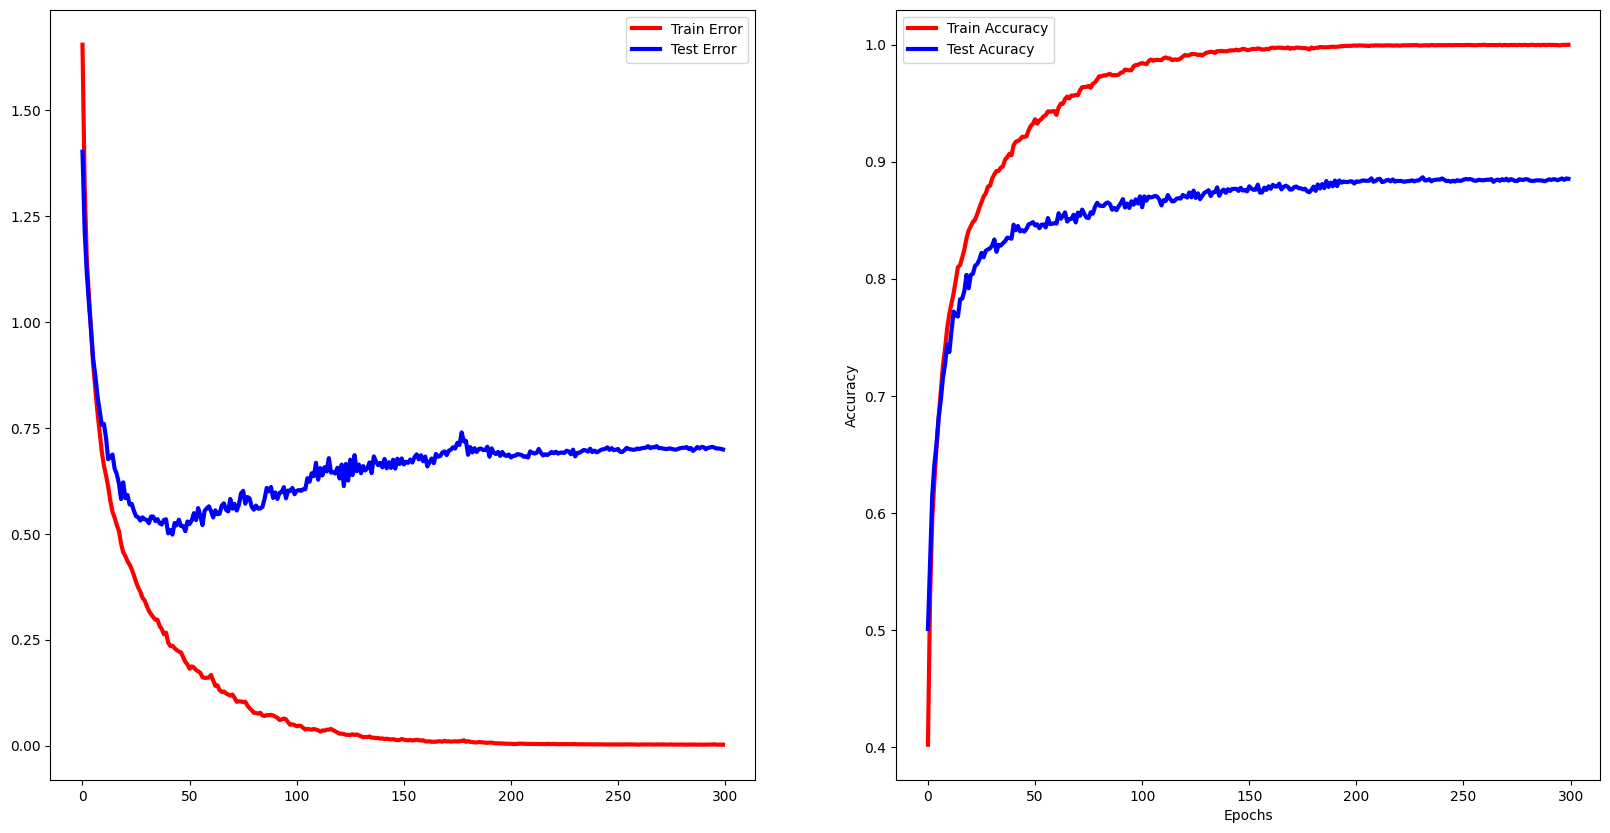

In [10]:
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
n = len(trainingLoss)
ax1.plot(range(n), trainingLoss, '-', linewidth='3', label='Train Error',color='Red')
ax1.plot(range(n), testingLoss, '-', linewidth='3', label='Test Error',color='Blue')

ax2.plot(range(n), trainingAccuracy, '-', linewidth='3', label='Train Accuracy',color='Red')
ax2.plot(range(n), testingAccuracy, '-', linewidth='3', label='Test Acuracy',color='Blue')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')

ax1.legend()
ax2.legend()
figure.savefig("./trainTestCurve.png")

In [11]:
corrects = 0.0
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    output = model(images)
    output = torch.argmax(output, dim=1)
    corrects += torch.sum(labels == output).float().item()
print(corrects/len(test_loader.dataset))

0.8853


In [12]:
!pip install onnx
model = resnet_model()
model.load_state_dict(torch.load('./saved_model.pt'))
# set the model to evaluation mode 
model.eval() 

# Let's create a sample input tensor  
x = torch.randn(4, 3, 32, 32)
torch.onnx.export(model, x, "final_resnet_model.onnx", opset_version = 11)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 71.2 MB/s eta 0:00:00


Model Config: 
-------------------------------------
N (# Layers)	: 4 
B (# Blocks)	: [3, 3, 2, 3] 
C (# Channels)	: [64, 128, 128, 256] 
F (Conv Kernel)	: [3, 3, 3, 3] 
K (Skip Kernel)	: [1, 1, 1, 1] 
P (Pool Kernel)	: 4
============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

